# Векторизованное тестирование на актуальных исторических данных

Прежде чем запускать данный алгоритм необходимо сначала актуализировать исторические данные. Для этого запускаем QUIK. Затем в QUIK запускаем алгоритм в основе которого лежит функция CreateDataSource, извлекающая данные из графиков движения цены.

В QUIK должны быть запущены стакан с котировками по нужному инструменту, график, таблица текущих торгов. А также скрипты получения данных и отправки транзакций.

# Получение и обработка актуальных данных данных

In [1]:
# Загружаем необходимые библиотеки и классы (treeinterpreter можно
# установить с помощью команды pip install treeinterpreter)
import time
import pickle
import datetime as dt
from pylab import mpl, plt # импорт библиотеки Matplotlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd

In [9]:
plt.style.use('seaborn-v0_8-darkgrid') # настройка стиля диаграмм
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [10]:
# загрузка данных из CSV-файла
# Столбцы для использования в качестве меток строки файла DataFrame либо даны как string name или индекс столбца.
# Если задана последовательность INT / STR, используется многоиндекс.
# Примечание: index_col = false может использоваться для форсирования Pands не использовать первый столбец как индекс,
# например, когда у вас есть неправильный файл с разделителями в конце каждой строки.
# Функция читает файл, в котором данные о последней свече находятся в первой строке 
raw = pd.read_csv('BRJ2\Data\BRJ2_Data.csv', index_col=0, parse_dates=False)

In [11]:
raw.info() # информация о файле

<class 'pandas.core.frame.DataFrame'>
Index: 3504 entries, 2022-3-30 to 2022-2-15
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    3504 non-null   object 
 1   Open    3504 non-null   float64
 2   High    3504 non-null   float64
 3   Low     3504 non-null   float64
 4   Close   3504 non-null   float64
 5   Volume  3504 non-null   float64
dtypes: float64(5), object(1)
memory usage: 191.6+ KB


In [12]:
# reverse_raw = raw[::-1] # когда берём всю коллекцию целиком
reverse_raw1 = raw[:200] # последние 200 свечей

In [13]:
reverse_raw = reverse_raw1[::-1]

In [14]:
reverse_raw.head()

,Time,Open,High,Low,Close,Volume
Date,,,,,,
2022-3-28,18:15,113.15,113.30,112.98,113.27,985.0
2022-3-28,18:20,113.27,113.56,113.23,113.55,1493.0
2022-3-28,18:25,113.54,114.10,113.51,114.04,1885.0
2022-3-28,18:30,114.00,114.05,113.71,113.80,1366.0
2022-3-28,18:35,113.82,114.07,113.76,113.99,873.0


In [15]:
reverse_raw.tail()

,Time,Open,High,Low,Close,Volume
Date,,,,,,
2022-3-30,17:10,111.88,112.84,111.72,112.66,2067.0
2022-3-30,17:15,112.66,112.91,112.37,112.45,809.0
2022-3-30,17:20,112.41,112.71,112.33,112.57,805.0
2022-3-30,17:25,112.65,112.72,112.31,112.50,636.0
2022-3-30,17:30,112.52,113.13,112.18,112.88,1488.0


In [16]:
reverse_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 2022-3-28 to 2022-3-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    200 non-null    object 
 1   Open    200 non-null    float64
 2   High    200 non-null    float64
 3   Low     200 non-null    float64
 4   Close   200 non-null    float64
 5   Volume  200 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.9+ KB


In [17]:
symbol = 'Close' # т.к. нам нужны цены закрытия пятиминутных свечей берём данные из колонки Close

In [18]:
m5_close = reverse_raw[symbol] # сохраняем серию в переменную с наиболее подходящим и информативным названием

In [19]:
# формирование подмножества данных и исключение нечисловых значений (NaN))
data = (pd.DataFrame(m5_close).dropna())

In [20]:
# расчёт логарифмической доходности
data['Доходность'] = np.log(data/data.shift(1))

In [21]:
# всегда применяем после shift, т.к. после shift появляются нечисловые значения NaN
data.dropna(inplace=True)

In [22]:
# Функция sign() является указателем на знак числа. Если число со знаком минус, то возвращает -1, если с плюсом, то 1
# Функция astype() преобразует в указанный тип данных, в данном случае int
data['Направление'] = np.sign(data['Доходность']).astype(int)

In [23]:
lags = 5 # поменяли количество 2 на 5

In [24]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Доходность'].shift(lag) # обратить внимание на каком этапе появляются data[col]
        cols.append(col)

In [25]:
create_lags(data)

In [26]:
data.dropna(inplace=True)

In [27]:
# дискретизация значений признаков с учётом параметра bins
def create_bins(data, bins=[0]):
    global cols_bin # объявляем глобальную переменную
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin' # преобразуем названия колонок
        # Функция digitize Возвращает индексы бинов,к которым принадлежит каждое значение во входном массиве.
        # Если значения в x выходят за пределы bins , соответственно возвращается 0 или len(bins). Т.е. отрицательные значения преобразуем в 0, а положительные в 1
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append (col_bin )

In [28]:
create_bins(data)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [29]:
grouped = data.groupby(cols_bin + ['Направление'])
grouped.size() # Отображение частоты возможных движений в зависимости от комбинаций значений признаков

lag_1_bin  lag_2_bin  lag_3_bin  lag_4_bin  lag_5_bin  Направление
0          0          0          0          0          -1             2
                                                        1             1
                                            1          -1             1
                                                        1             1
                                 1          0          -1             2
                                                                     ..
1          1          1          0          1           1             2
                                 1          0          -1             4
                                                        1             2
                                            1          -1             2
                                                        1             4
Length: 64, dtype: int64

In [30]:
# Преобразование объекта DataFrame, чтобы частоты хранились по столбцам.
res = grouped['Направление'].size().unstack(fill_value=0)

In [31]:
# Определение наиболее часто встречающегося значения для каждой комбинации значений признаков.
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [32]:
# Определение наиболее часто встречающегося значения для каждой комбинации значений признаков.
res.style.apply(highlight_max, axis=1)

In [33]:
# Преобразование полученного частотного распределения в торговую стратегию
# Функция where() возвращает элементы, которые могут выбираться из двух массивов в зависимости от условия
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

In [34]:
(data['Направление'] == data['pos_freq']).value_counts()

False    99
True     95
Name: count, dtype: int64

In [35]:
data['strat_freq'] = data['pos_freq'] * data['Доходность']

# Обработка данных с помощью алгоритма MLPClassifier

In [36]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)

In [37]:
%time model.fit(data[cols_bin], data['Направление']) 

CPU times: total: 19.4 s
Wall time: 6.64 s


e:\repo\TradingAlgorithmsandAutomations\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [38]:
# прогнозируем ту колонку, которая нам нужна
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [39]:
data['pos_dnn_sk'].head(10)

Date
2022-3-29   -1
2022-3-29    1
2022-3-29   -1
2022-3-29   -1
2022-3-29   -1
2022-3-29    1
2022-3-29   -1
2022-3-29   -1
2022-3-29    1
2022-3-29    1
Name: pos_dnn_sk, dtype: int32

In [40]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['Доходность']

In [41]:
data[['Доходность', 'strat_dnn_sk']].sum().apply(np.exp) 

Доходность      0.988095
strat_dnn_sk    1.309502
dtype: float64

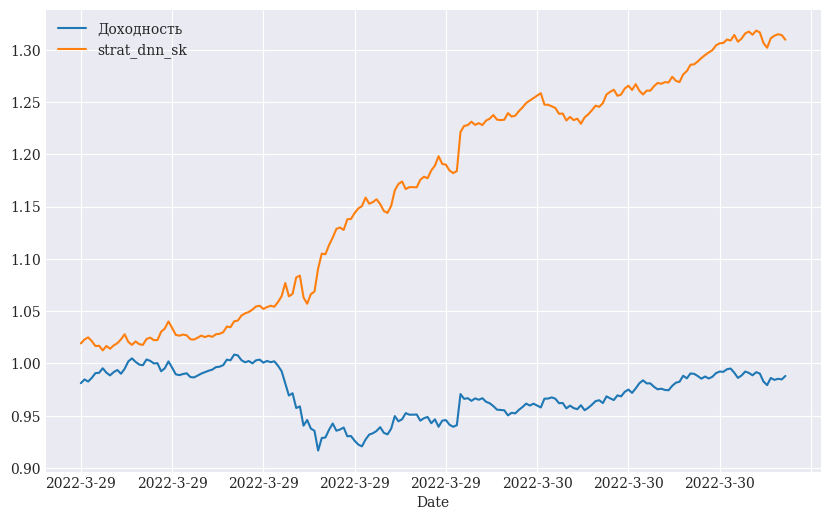

In [42]:
data[['Доходность', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [43]:
pickle.dump(model, open('algorithm_MLPClassifier.pkl', 'wb')) # сохраняем модель в файл, который будет храниться в той же папке

# Загрузка сохранённого объекта модели

In [44]:
algorithm = pickle.load(open('algorithm_MLPClassifier.pkl', 'rb')) # загружаем модель из сохранённого файла

# Запуск алгоритма в режиме реального времени с периодическим обновлением данных

In [38]:
# разобраться с ебучим циклом он сука не работает. Признаком его работы должно быть появление файла signal
# заебись, вроде работает
while True:
    struct = time.localtime()
    if struct.tm_sec == 40:
        # загрузка данных из CSV-файла
        # Столбцы для использования в качестве меток строки файла DataFrame либо даны как string name или индекс столбца.
        # Если задана последовательность INT / STR, используется многоиндекс.
        # Примечание: index_col = false может использоваться для форсирования Pands не использовать первый столбец как индекс,
        # например, когда у вас есть неправильный файл с разделителями в конце каждой строки.
        # Функция читает файл, в котором данные о последней свече находятся в первой строке 
        raw = pd.read_csv('BRJ2\Data\BRJ2_Data.csv', index_col=0, parse_dates=False)
        reverse_raw1 = raw[:200] # реверс набора данных
        reverse_raw = reverse_raw1[::-1]
        symbol = 'Close' # т.к. нам нужны цены закрытия пятиминутных свечей берём данные из колонки Close
        m5_close = reverse_raw[symbol] # сохраняем серию в переменную с наиболее подходящим и информативным названием
        # формирование подмножества данных и исключение нечисловых значений (NaN))
        data = (pd.DataFrame(m5_close).dropna())
        # расчёт логарифмической доходности
        data['Доходность'] = np.log(data/data.shift(1))
        # всегда применяем после shift, т.к. после shift появляются нечисловые значения NaN
        data.dropna(inplace=True)
        # Функция sign() является указателем на знак числа. Если число со знаком минус, то возвращает -1, если с плюсом, то 1
        # Функция astype() преобразует в указанный тип данных, в данном случае int
        data['Направление'] = np.sign(data['Доходность']).astype(int)
        features = data['Направление'].iloc[-(lags + 1):-1]
        features = features.values.reshape(1, -1)
        #model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)
        #%time model.fit(features)
        signal = model.predict(features)[0]
        f = open('BRJ2\Signal_and_transaction\signal.txt', 'w') # вместо а+ лучше поставить w или w+, т.к. дозапись необязательна
        f.write(str(signal)) # секунды убрать, мешать будут и перевод строки
        f.close()
        continue
    else:
        continue
        

KeyboardInterrupt: 